### **Dataset from:**
### 1. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
### 2. https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset

## **Notebook setup**

In [1]:
import sys
from pathlib import Path

cwd = Path().resolve()

for parent in [cwd] + list(cwd.parents):
    if (parent / "src").exists():
        ROOT_DIR = parent
        break

sys.path.insert(0, str(ROOT_DIR))

print("ROOT_DIR:", ROOT_DIR)

ROOT_DIR: D:\Klasifikasi_Pneumonia


## **Import Required Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.training.train import train_model
from src.models.resnet50 import build_model
from src.config.load_config import load_config
from src.training.callbacks import get_callbacks
from src.data.dataset_loader import create_generators
from src.evaluation.evaluate_model import evaluate_model

config = load_config()

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_path = ROOT_DIR / config["paths"]["dataset_csv"]
df = pd.read_csv(df_path)
df.head()

,img_path,height,width,image_size_kb,label
0,D:/Klasifikasi_Pneumonia/data/processed/chest_...,224,224,17.817,Pneumonia
1,D:/Klasifikasi_Pneumonia/data/processed/chest_...,224,224,16.907,Pneumonia
2,D:/Klasifikasi_Pneumonia/data/processed/chest_...,224,224,11.370,Normal
3,D:/Klasifikasi_Pneumonia/data/processed/chest_...,224,224,13.966,Normal
4,D:/Klasifikasi_Pneumonia/data/processed/chest_...,224,224,18.032,Normal


## **Split Dataset**

In [4]:
df_train_val, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)

df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.25,
    stratify=df_train_val["label"],
    random_state=42,
)

print(f"Train set size: {len(df_train)}")
print(f"Val set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 12460
Val set size: 4154
Test set size: 4154


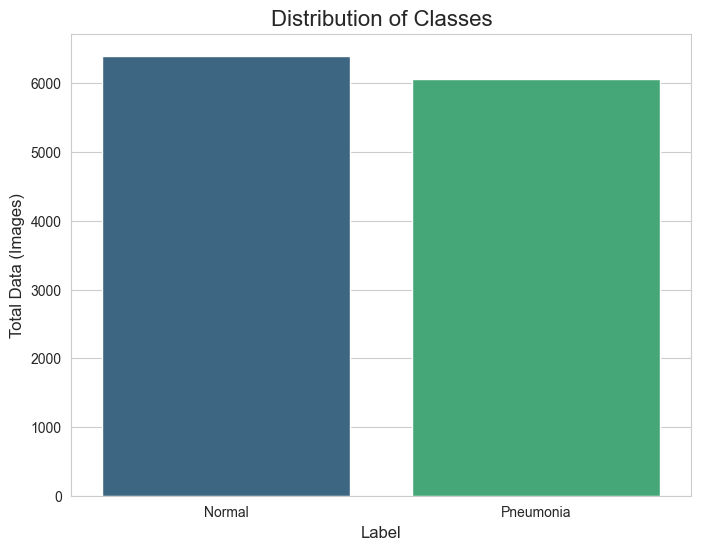

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=["Normal", "Pneumonia"], y=df_train["label"].value_counts().sort_index(), palette="viridis")
plt.title("Distribution of Classes", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Total Data (Images)", fontsize=12)
plt.show()

# **Experiment 01 (Without Transfer Learning and No Augmentation Data)**

## **No Augmentation**

In [6]:
train_generator_no_aug, val_generator_no_aug, test_generator_no_aug = create_generators(
    df_train,
    df_val,
    df_test,
    use_data_augmentation=False,
)

[INFO] Creating Generator with Batch Size: 32
Found 12460 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.


## **Modelling**

In [7]:
model_from_scratch = build_model(
    model_name="ResNet50_chest_xray_classifier_from_scratch",
    use_transfer_learning=False,
)

model_from_scratch.summary()

Model: "ResNet50_chest_xray_classifier_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 24,059,393 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
history_from_scrath = train_model(
    model_from_scratch,
    train_generator_no_aug,
    val_generator_no_aug,
    callbacks=get_callbacks(),
)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1910s 5s/step - accuracy: 0.8520 - loss: 0.3501 - precision: 0.8484 - recall: 0.8470 - val_accuracy: 0.8503 - val_loss: 0.5766 - val_precision: 0.8761 - val_recall: 0.8058 - learning_rate: 0.0010
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1913s 5s/step - accuracy: 0.8783 - loss: 0.2571 - precision: 0.9052 - recall: 0.8374 - val_accuracy: 0.8832 - val_loss: 0.2754 - val_precision: 0.8820 - val_recall: 0.8772 - learning_rate: 0.0010
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1405s 4s/step - accuracy: 0.8871 - loss: 0.2324 - precision: 0.9280 - recall: 0.8323 - val_accuracy: 0.8669 - val_loss: 0.2794 - val_precision: 0.9045 - val_recall: 0.8118 - learning_rate: 0.0010
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8857 - loss: 0.2283 - precision: 0.9304 - recall: 0.8252
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
390/390 ━━━━━━━━━━━━━━━━━━━━ 1408s 4s/step - accuracy: 0.8891 - loss: 0.2229 - precision: 0.93

## **Evaluate**

In [9]:
loss_no_aug, accuracy_no_aug, recall_no_aug, precision_no_aug = model_from_scratch.evaluate(test_generator_no_aug, steps=len(test_generator_no_aug))

print(f"Test Loss: {loss_no_aug:.4f}, Test Accuracy: {accuracy_no_aug:.4f}, Test Recall: {recall_no_aug:.4f}, Test Precision: {precision_no_aug:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 103s 795ms/step - accuracy: 0.8657 - loss: 0.3013 - precision: 0.8090 - recall: 0.9475
Test Loss: 0.3013, Test Accuracy: 0.8657, Test Recall: 0.9475, Test Precision: 0.8090


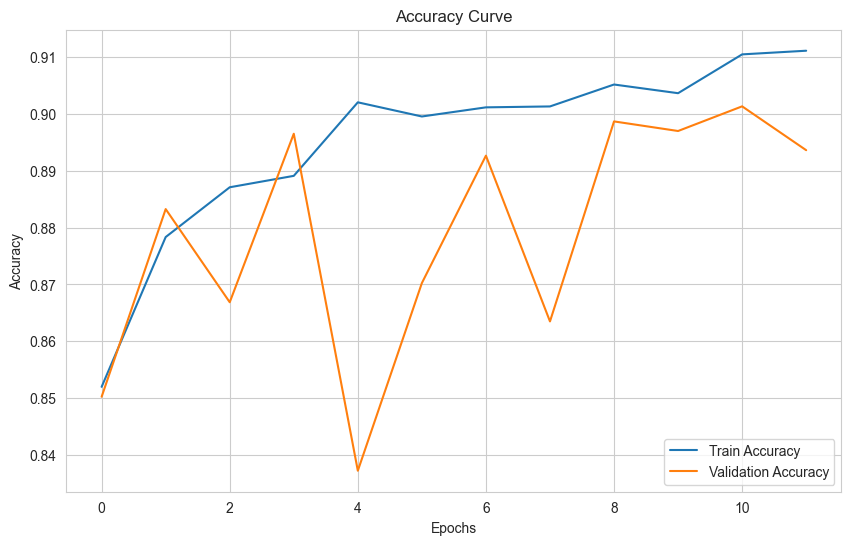

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history_from_scrath.history["accuracy"], label="Train Accuracy")
plt.plot(history_from_scrath.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc="lower right")
plt.show()

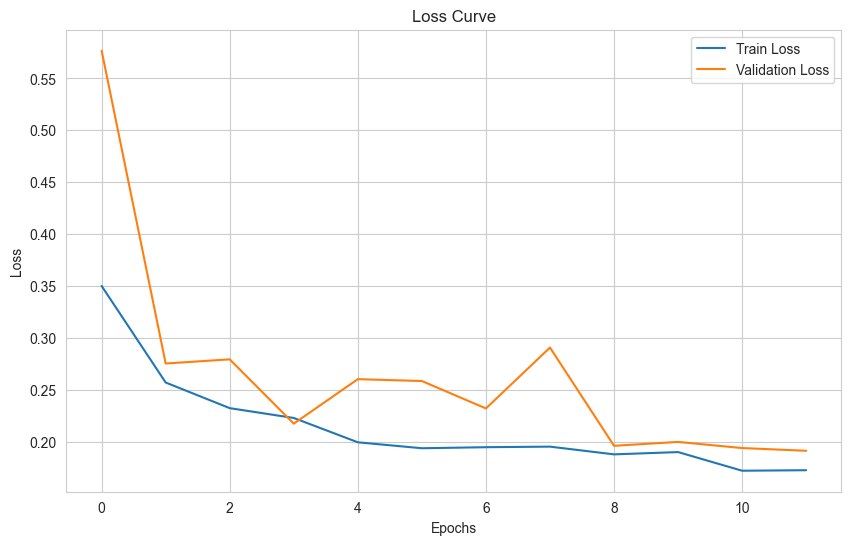

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history_from_scrath.history["loss"], label="Train Loss")
plt.plot(history_from_scrath.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(loc="upper right")
plt.show()

In [27]:
y_true_no_aug = test_generator_no_aug.classes
y_prob_no_aug = model_from_scratch.predict(test_generator_no_aug, steps=len(test_generator_no_aug))
y_pred_classes_no_aug = (y_prob_no_aug > 0.5).astype(int).flatten()


print(classification_report(y_true_no_aug, y_pred_classes_no_aug, target_names=["Normal", "Pneumonia"]))

130/130 ━━━━━━━━━━━━━━━━━━━━ 92s 709ms/step
              precision    recall  f1-score   support

      Normal       0.94      0.79      0.86      2134
   Pneumonia       0.81      0.95      0.87      2020

    accuracy                           0.87      4154
   macro avg       0.87      0.87      0.87      4154
weighted avg       0.88      0.87      0.87      4154



In [13]:
evaluate_metrics_baseline = evaluate_model(
    y_true=y_true_no_aug,
    y_pred=y_pred_classes_no_aug,
)

print("-" * 50)
print(f"Precision: {evaluate_metrics_baseline['precision']:.4f}, Recall: {evaluate_metrics_baseline['recall']:.4f}, F1-Score: {evaluate_metrics_baseline['f1_score']:.4f}, AUC: {evaluate_metrics_baseline['auc']:.4f}")
print(f"Confusion Matrix:\n{evaluate_metrics_baseline['confusion_matrix']}")

--------------------------------------------------
Precision: 0.8766, Recall: 0.8657, F1-Score: 0.8650, AUC: 0.8679
Confusion Matrix:
[[1682  452]
 [ 106 1914]]


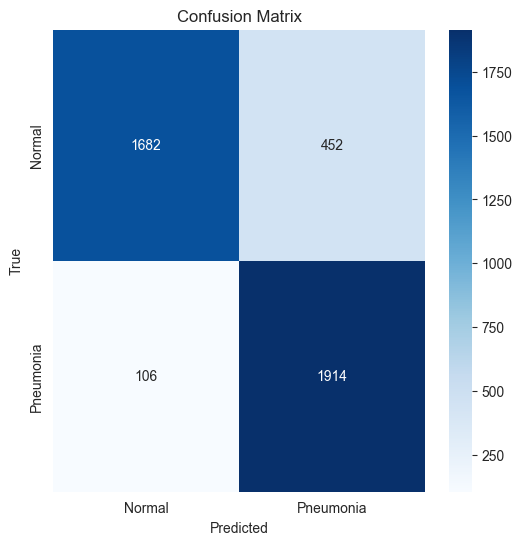

In [14]:
plt.figure(figsize=(6, 6))
sns.heatmap(evaluate_metrics_baseline["confusion_matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..120.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


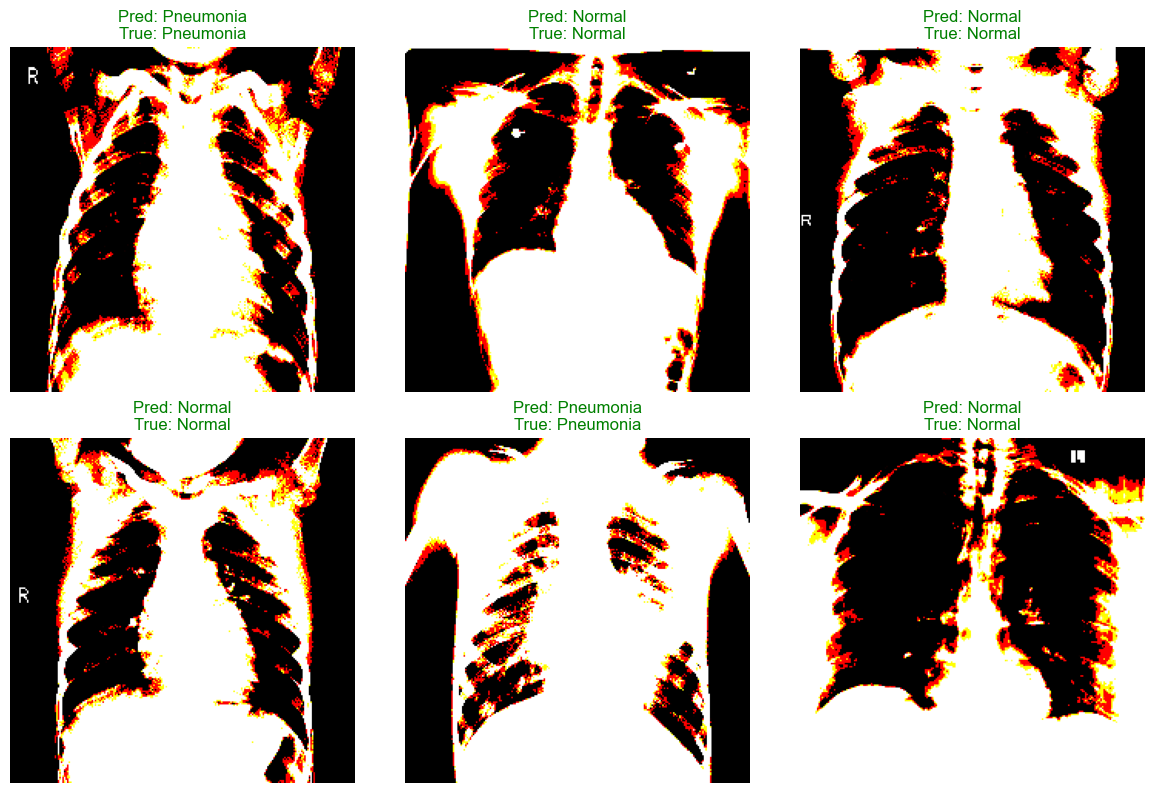

In [15]:
batch_images = test_generator_no_aug[0][0] 

plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    predicted_label = "Pneumonia" if y_pred_classes_no_aug[i] == 1 else "Normal"
    true_label = "Pneumonia" if y_true_no_aug[i] == 1 else "Normal"
    
    color = "green" if predicted_label == true_label else "red"
    
    plt.imshow(batch_images[i]) 
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Experiment 02 (With Transfer Learning and Augmentation Data)**

## **Augmentation**

In [16]:
train_generator, val_generator, test_generator = create_generators(
    df_train,
    df_val,
    df_test,
)

[INFO] Creating Generator with Batch Size: 32
Found 12460 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.


## **Modelling**

In [17]:
model = build_model(model_name="resnet50_classifier",)

model.summary()

Model: "resnet50_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
history = train_model(
    model,
    train_generator,
    val_generator,
    callbacks=get_callbacks(),
)

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.8833 - loss: 0.2295 - precision: 0.8887 - recall: 0.8688 - val_accuracy: 0.8897 - val_loss: 0.2120 - val_precision: 0.9682 - val_recall: 0.7994 - learning_rate: 0.0010
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1220s 3s/step - accuracy: 0.8896 - loss: 0.2142 - precision: 0.9076 - recall: 0.8607 - val_accuracy: 0.9011 - val_loss: 0.1983 - val_precision: 0.9492 - val_recall: 0.8415 - learning_rate: 0.0010
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 1258s 3s/step - accuracy: 0.8975 - loss: 0.2045 - precision: 0.9217 - recall: 0.8625 - val_accuracy: 0.8801 - val_loss: 0.2057 - val_precision: 0.8606 - val_recall: 0.8990 - learning_rate: 0.0010
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.8981 - loss: 0.2008 - precision: 0.9272 - recall: 0.8577 - val_accuracy: 0.8979 - val_loss: 0.2001 - val_precision: 0.9705 - val_recall: 0.8148 - learning_rate: 0.0010
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accur

## **Evaluate**

In [29]:
loss, accuracy, recall, precision = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Recall: {recall:.4f}, Test Precision: {precision:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 117s 899ms/step - accuracy: 0.8917 - loss: 0.2000 - precision: 0.8796 - recall: 0.9005
Test Loss: 0.2000, Test Accuracy: 0.8917, Test Recall: 0.9005, Test Precision: 0.8796


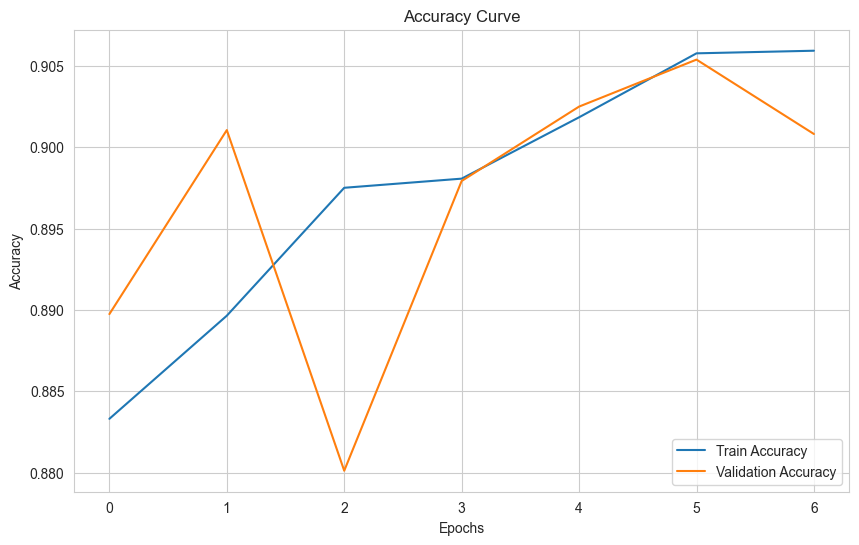

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc="lower right")
plt.show()

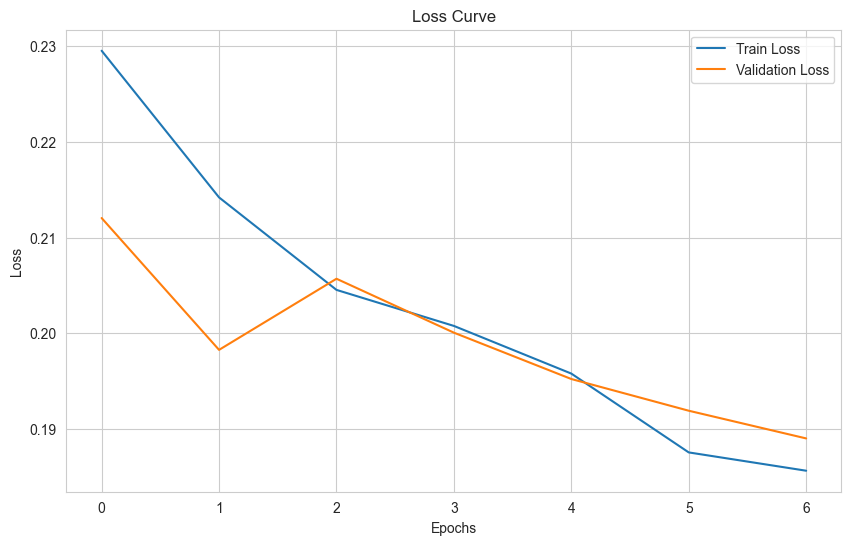

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(loc="upper right")
plt.show()

In [32]:
y_true = test_generator.classes
y_prob = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = (y_prob > .5).astype(int).flatten()

print("-" * 50)
print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Pneumonia"]))

130/130 ━━━━━━━━━━━━━━━━━━━━ 1005s 8s/step
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.90      0.88      0.89      2134
   Pneumonia       0.88      0.90      0.89      2020

    accuracy                           0.89      4154
   macro avg       0.89      0.89      0.89      4154
weighted avg       0.89      0.89      0.89      4154



In [36]:
evaluate_metrics_proposed = evaluate_model(
    y_true=y_true,
    y_pred=y_pred_classes,
)

print(f"Precision: {evaluate_metrics_proposed['precision']:.4f}, Recall: {evaluate_metrics_proposed['recall']:.4f}, F1-Score: {evaluate_metrics_proposed['f1_score']:.4f}, AUC: {evaluate_metrics_proposed['auc']:.4f}")
print(f"Confusion Matrix:\n{evaluate_metrics_proposed['confusion_matrix']}")

Precision: 0.8919, Recall: 0.8917, F1-Score: 0.8917, AUC: 0.8919
Confusion Matrix:
[[1885  249]
 [ 201 1819]]


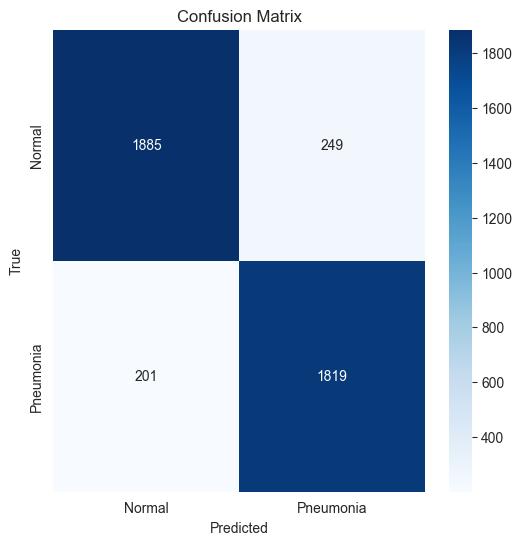

In [37]:
plt.figure(figsize=(6, 6))
sns.heatmap(evaluate_metrics_proposed["confusion_matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..120.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


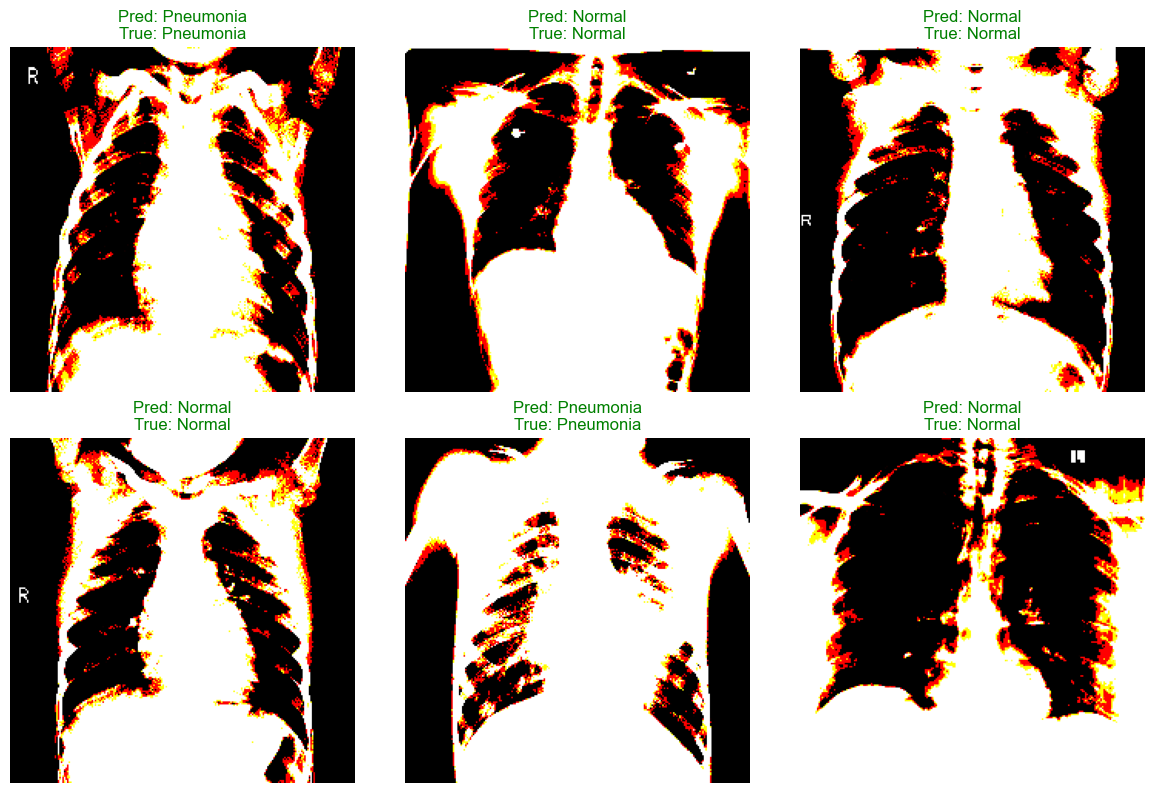

In [38]:
batch_images = test_generator[0][0] 

plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    predicted_label = "Pneumonia" if y_pred_classes[i] == 1 else "Normal"
    true_label = "Pneumonia" if y_true[i] == 1 else "Normal"
    
    color = "green" if predicted_label == true_label else "red"
    
    plt.imshow(batch_images[i]) 
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Result**

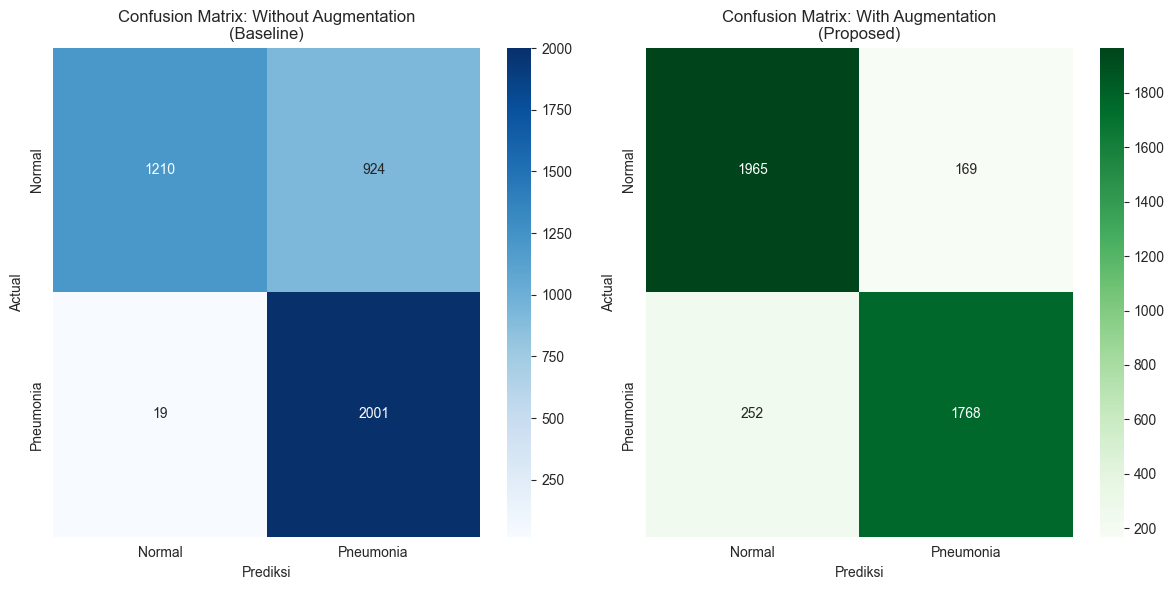

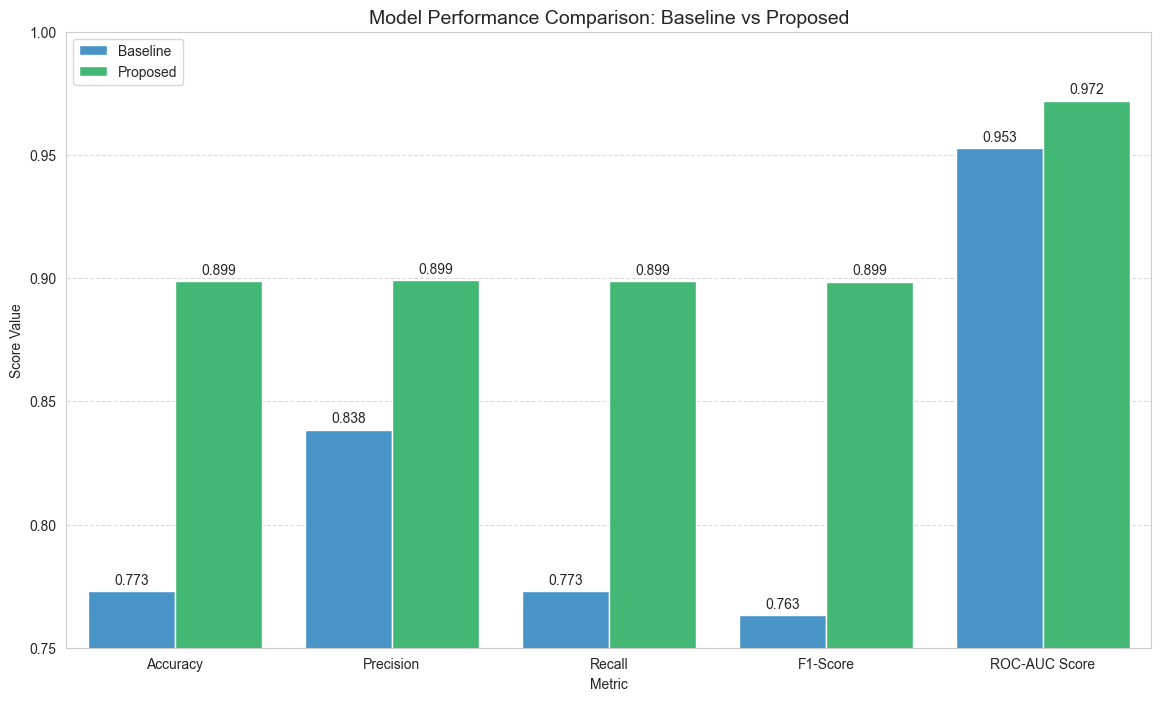

In [ ]:
# Calculate metrics for both models
acc_baseline    = accuracy_score(y_true_no_aug, y_pred_classes_no_aug)
prec_baseline   = precision_score(y_true_no_aug, y_pred_classes_no_aug, average='weighted')
recall_baseline = recall_score(y_true_no_aug, y_pred_classes_no_aug, average='weighted')
f1_baseline     = f1_score(y_true_no_aug, y_pred_classes_no_aug, average='weighted')

acc_proposed    = accuracy_score(y_true, y_pred_classes)
prec_proposed   = precision_score(y_true, y_pred_classes, average='weighted')
recall_proposed = recall_score(y_true, y_pred_classes, average='weighted')
f1_proposed     = f1_score(y_true, y_pred_classes, average='weighted')

# Prepare DataFrame for visualization
metrics_data = {
    'Model': [
        'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline',
        'Proposed', 'Proposed', 'Proposed', 'Proposed', 'Proposed',
    ],
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC Score',
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC Score',
    ],
    'Score': [
        accuracy_no_aug, evaluate_metrics_baseline["precision"], evaluate_metrics_baseline["recall"], evaluate_metrics_baseline["f1_score"], evaluate_metrics_baseline["auc"],
        acc_proposed, evaluate_metrics_proposed["precision"], evaluate_metrics_proposed["recall"], evaluate_metrics_proposed["f1_score"], evaluate_metrics_proposed["auc"]
    ]
}

df_metrics = pd.DataFrame(metrics_data)

# ---- Visualization 1: Confusion Matrix Comparison ----
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
labels = ['Normal', 'Pneumonia']

# Plot Baseline
sns.heatmap(evaluate_metrics_baseline["confusion_matrix"], annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title('Confusion Matrix: Without Augmentation\n(Baseline)')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Actual')

# Plot Proposed
sns.heatmap(evaluate_metrics_proposed["confusion_matrix"], annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title('Confusion Matrix: With Augmentation\n(Proposed)')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ---- Visualization 2: Bar Chart Comparison of Metrics ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics, palette=['#3498db', '#2ecc71'])

# Adding numbers above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('Model Performance Comparison: Baseline vs Proposed', fontsize=14)
plt.ylim(0.75, 1.0) # Zoom in to the 80-100% range to highlight differences
plt.ylabel('Score Value')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()